In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mrmr import mrmr_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,f1_score
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
import scikitplot as skplt
from lightgbm import LGBMClassifier
#from imblearn.over_sampling import SMOTE
import shap
import re

In [2]:
heart_df = pd.read_csv("CVD_cleaned.csv")

In [3]:
heart_df = heart_df.rename(columns = lambda x:re.sub('_', '', x))
heart_df = heart_df.rename(columns = lambda x:re.sub('\W', '', x))

In [4]:
heart_df

,GeneralHealth,Checkup,Exercise,HeartDisease,SkinCancer,OtherCancer,Depression,Diabetes,Arthritis,Sex,AgeCategory,Heightcm,Weightkg,BMI,SmokingHistory,AlcoholConsumption,FruitConsumption,GreenVegetablesConsumption,FriedPotatoConsumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308849,Very Good,Within the past year,Yes,No,No,No,No,No,No,Male,25-29,168.0,81.65,29.05,No,4.0,30.0,8.0,0.0
308850,Fair,Within the past 5 years,Yes,No,No,No,No,Yes,No,Male,65-69,180.0,69.85,21.48,No,8.0,15.0,60.0,4.0
308851,Very Good,5 or more years ago,Yes,No,No,No,Yes,"Yes, but female told only during pregnancy",No,Female,30-34,157.0,61.23,24.69,Yes,4.0,40.0,8.0,4.0
308852,Very Good,Within the past year,Yes,No,No,No,No,No,No,Male,65-69,183.0,79.38,23.73,No,3.0,30.0,12.0,0.0


# Data Cleaning/Exploration

In [5]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   GeneralHealth               308854 non-null  object 
 1   Checkup                     308854 non-null  object 
 2   Exercise                    308854 non-null  object 
 3   HeartDisease                308854 non-null  object 
 4   SkinCancer                  308854 non-null  object 
 5   OtherCancer                 308854 non-null  object 
 6   Depression                  308854 non-null  object 
 7   Diabetes                    308854 non-null  object 
 8   Arthritis                   308854 non-null  object 
 9   Sex                         308854 non-null  object 
 10  AgeCategory                 308854 non-null  object 
 11  Heightcm                    308854 non-null  float64
 12  Weightkg                    308854 non-null  float64
 13  BMI           

<AxesSubplot:>

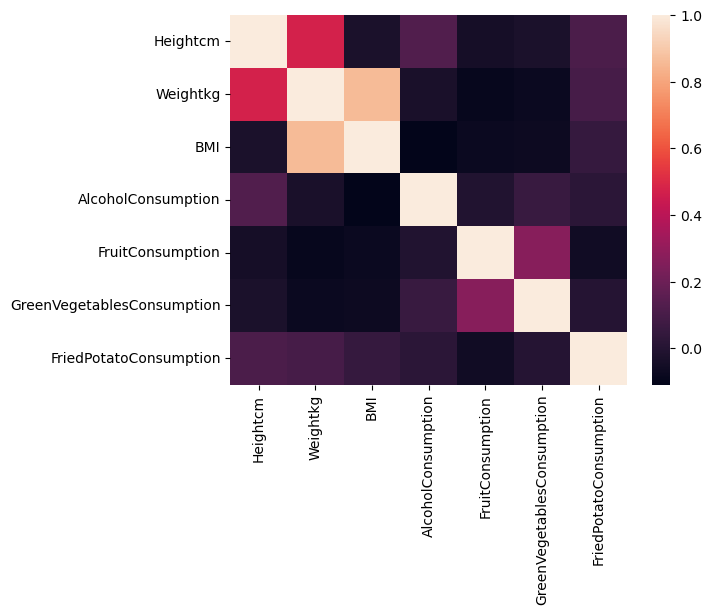

In [6]:
sns.heatmap(heart_df.corr())

In [7]:
# height,weight and BMI are highly correlated so we drop the height and weight 

In [8]:
heart_df.drop(['Heightcm','Weightkg'],axis=1,inplace=True)

In [9]:
# Those that have/had diabetes are the ones that also have the highest BMI. It seems that Females are on top of this category

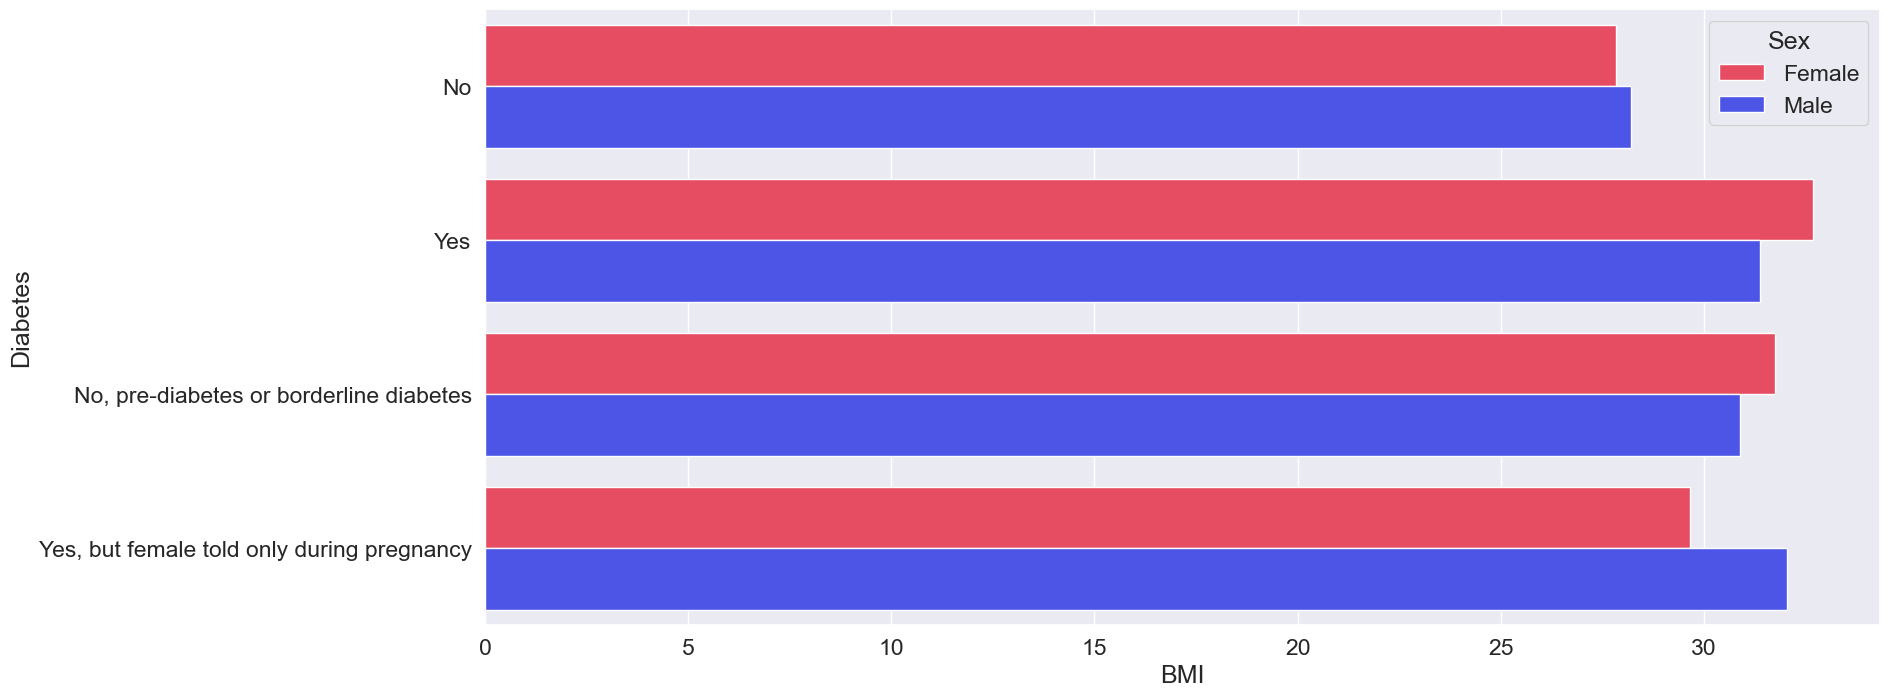

In [10]:
plt.figure(figsize=(18,8))
palette=["#ff334f","#333fff"]
sns.set(font_scale=1.5)
ax=sns.barplot( x="BMI",y="Diabetes",hue = 'Sex', data=heart_df,palette=palette,errorbar=None)
plt.savefig('pick2.png', transparent=True)

In [11]:
# Boxplot : 

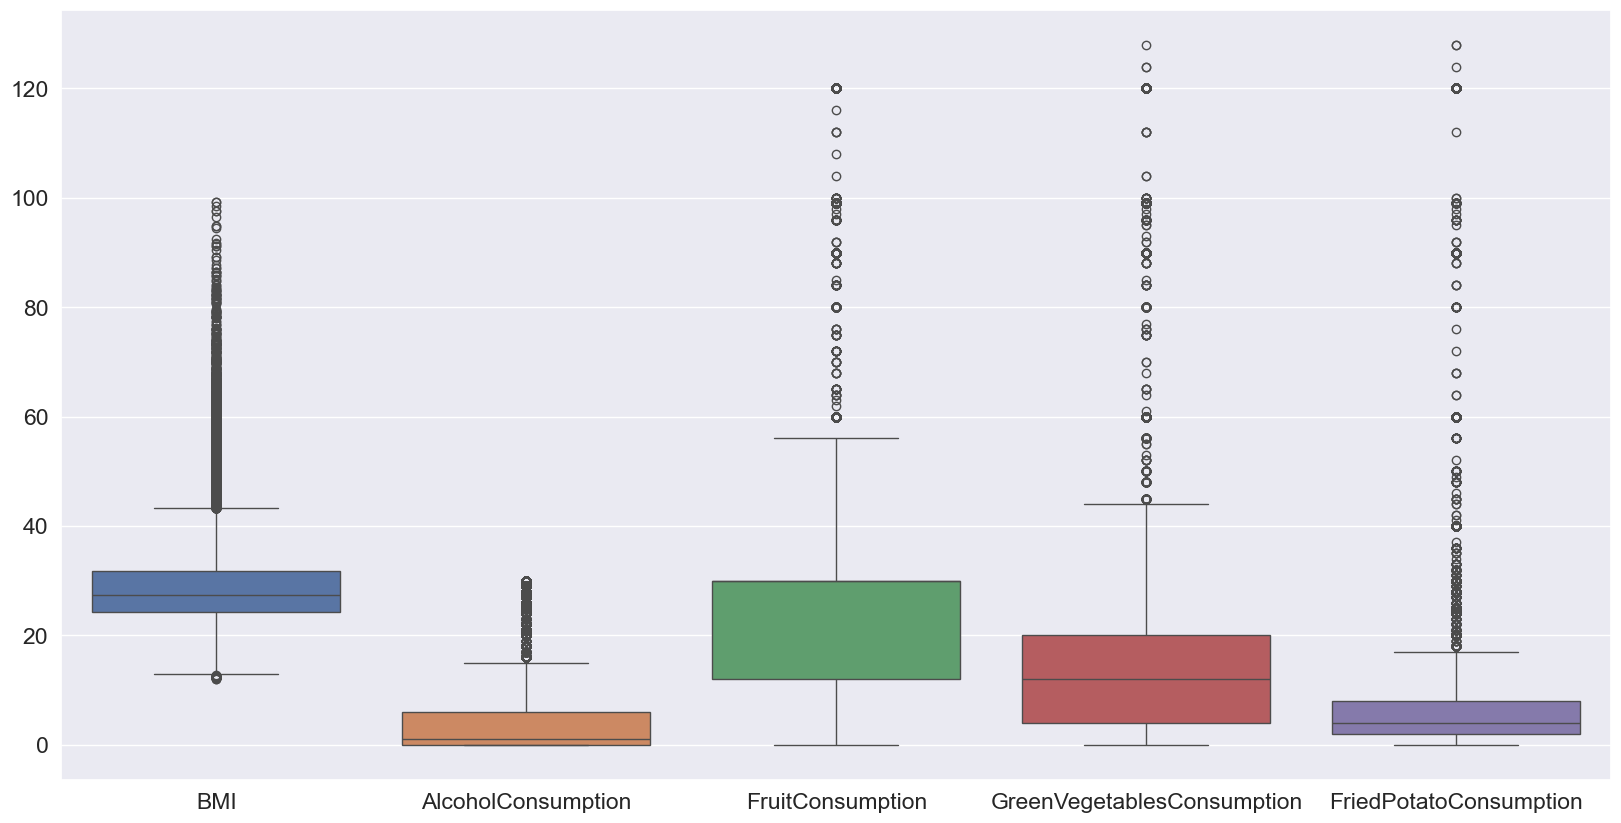

In [12]:
plt.figure(figsize=(20,10))
fig=sns.boxplot(heart_df.drop(["HeartDisease"],axis=1))
plt.savefig('boxplot.png', transparent=True)

In [13]:
#Checkups

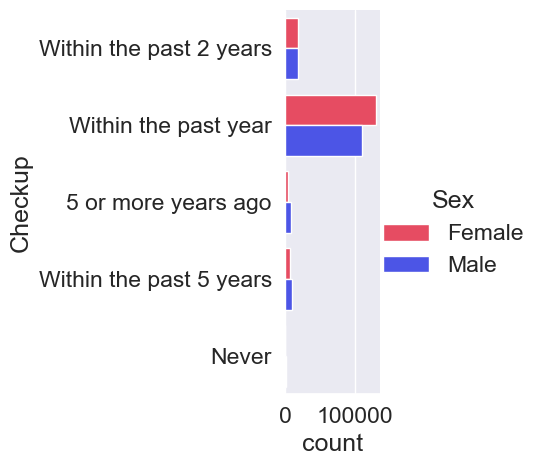

In [14]:
sns.catplot(data=heart_df, y="Checkup", hue="Sex", kind="count",palette=palette)
plt.savefig('image.png', transparent=True)

In [15]:
#Impact of Exercise on BMI

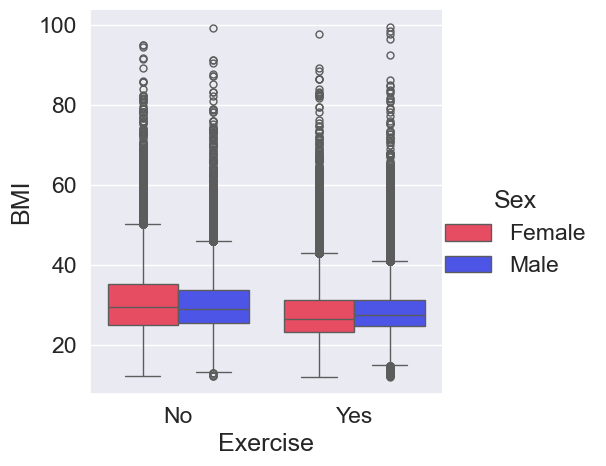

In [16]:
sns.catplot(data=heart_df, x="Exercise", y="BMI", hue="Sex", palette=palette,kind="box")
plt.savefig('bmi.png', transparent=True)

# Model Selection

In [17]:
#Get dummies

In [18]:
X=heart_df.drop(["HeartDisease"],axis=1)
y=heart_df["HeartDisease"]

In [19]:
for col in X.columns:
    if col != "Diabetes":
        X[col] = X[col].replace(["No","Yes"],[0,1])
        X[col] = X[col].replace(["Female","Male"],[0,1])

In [20]:
y.replace(["No","Yes"],[0,1],inplace=True)

In [21]:
X=pd.get_dummies(X)

In [22]:
X = X.rename(columns = lambda x:re.sub('[+,_-]', '', x))

In [23]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=20,stratify=y)

In [24]:
y_train.value_counts()

0    227106
1     19977
Name: HeartDisease, dtype: int64

In [25]:
# Downsampling

In [26]:
df_train=X_train.copy()
df_train["Heart_Disease"]=y_train.copy()

In [27]:
down_df= df_train.groupby('Heart_Disease',as_index=False).apply(lambda x:x.sample(n=19977)).reset_index(drop=True)

In [28]:
down_df["Heart_Disease"].value_counts()

0    19977
1    19977
Name: Heart_Disease, dtype: int64

In [29]:
X_train=down_df.drop(["Heart_Disease"],axis=1)
y_train=down_df["Heart_Disease"]

In [30]:
y_train.value_counts()

0    19977
1    19977
Name: Heart_Disease, dtype: int64

In [31]:
#Try robust scaler 

In [ ]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
# LGBMClassifier

In [32]:
model = LGBMClassifier(random_state=20)

In [33]:
model.fit(X_train,y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19977, number of negative: 19977
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 39954, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(random_state=20)

In [34]:
y_pred=model.predict(X_test)

In [35]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.71      0.82     56777
           1       0.20      0.81      0.32      4994

    accuracy                           0.72     61771
   macro avg       0.59      0.76      0.57     61771
weighted avg       0.91      0.72      0.78     61771



In [36]:
confusion_matrix(y_test, y_pred)

array([[40277, 16500],
       [  957,  4037]], dtype=int64)

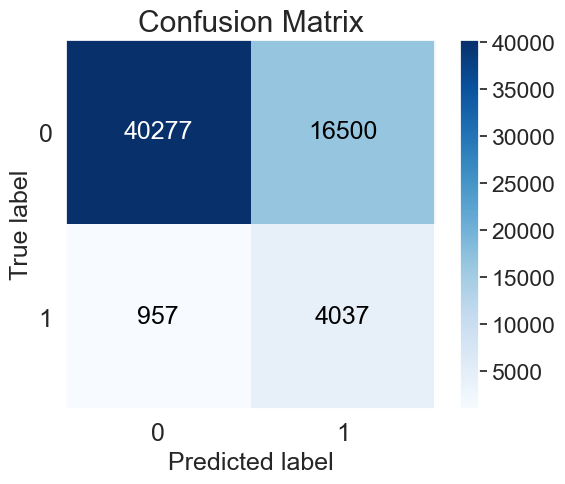

In [37]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.savefig('corr_matrix.png', transparent=True)

In [38]:
#Hyperparameter tuning 

In [39]:
pipe=Pipeline([('lgbm',LGBMClassifier(random_state=20))])

In [40]:
parameters={
    'lgbm__max_depth':[3,4,5,6,7],
    'lgbm__num_leaves':[6,7,8,15,31],
    'lgbm__min_data_in_leaf':[5,10,20]
}

In [41]:
CV=GridSearchCV(pipe,parameters,scoring='recall')

In [42]:
CV.fit(X_train,y_train)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 15982, number of negative: 15981
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500016 -> initscore=0.000063
[LightGBM] [Info] Start training from score 0.000063
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[Ligh

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 31964, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 15982, number of negative: 15981
[LightGBM] [Info] Auto-choosing row-wise multi-threading, 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499984 -> initscore=-0.000063
[LightGBM] [Info] Start training from score -0.000063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_sample

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 15982, number of negative: 15981
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500016 -> initscore=0.000063
[LightGBM] [Info] Start training from score 0.000063

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 15982, number of negative: 15981
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500016 -> initscore=0.000063
[LightGBM] [Info] Start training from score 0.000063

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 15982, number of negative: 15981
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500016 -> initscore=0.000063
[LightGBM] [Info] Start training from score 0.000063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[Light

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500016 -> initscore=0.000063
[LightGBM] [Info] Start training from score 0.000063
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 15982, number of negative: 15981

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 15982, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 31964, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 15982, number of negative: 15981
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not 

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 15981, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499984 -> initscore=-0.000063
[LightGBM] [Info] Start training from score -0.000063
[Li

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 15981, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499984 -> initscore=-0.000063
[LightGBM] [Info] Start training from score -0.000063
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 15982, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001832 seconds.
You can se

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 15982, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 31964, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> in

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 15981, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499984 -> initscore=-0.000063
[LightGBM] [Info] Start training from score -0.000063
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 15981, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499984 -> initscore=-0.000063
[LightGBM] [Info] Start training from score -0.0000

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 15981, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499984 -> initscore=-0.000063
[LightGBM] [Info] Start training from score -0.000063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 15982, number of negative: 15981
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500016 -> initscore=0.000063
[LightGBM] [Info] Start training from score 0.000063
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 15982, number of negative: 15981
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500016 -> initscore=0.000063
[LightGBM] [Info] Start training from score 0.000063
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 15981, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499984 -> initscore=-0.000063
[LightGBM] [Info] Start training from score -0.000063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 15982, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 31964, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 15982, number of negative: 15981
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500016 -> initscore=0.000063
[LightGBM] [Info] Start training from score 0.000063
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[Ligh

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 15982, number of negative: 15981
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500016 -> initscore=0.000063
[LightGBM] [Info] Start training from score 0.000063
[Ligh

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 15981, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 15982, number of negative: 15981
[LightGBM] [Info] Auto-choosing row-wise multi-threadin

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 15981, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499984 -> initscore=-0.000063
[LightGBM] [Info] Start training from score -0.0000

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 15981, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499984 -> initscore=-0.000063
[LightGBM] [Info] Start training from score -0.0000

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500016 -> initscore=0.000063
[LightGBM] [Info] Start training from score 0.000063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 15982, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 31964, number of used featur

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 15981, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499984 -> initscore=-0.000063
[LightGBM] [Info] Start training from score -0.0000

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 15981, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499984 -> initscore=-0.000063
[LightGBM] [Info] Start training from score -0.0000

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in featu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 15981, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499984 -> initscore=-0.000063
[LightGBM] [Info] Start training from score -0.000063
[Li

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 15981, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499984 -> initscore=-0.000063
[LightGBM] [Info] Start training from score -0.000063
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 15982, number of negative: 15981
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Num

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 15982, number of negative: 15981
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500016 -> initscore=0.000063
[LightGBM] [Info] Start training from score 0.000063

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 15982, number of negative: 15981
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 15981, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499984 -> initscore=-0.000063
[LightGBM] [Info] Start training from score -0.0000

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 15981, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499984 -> initscore=-0.000063
[LightGBM] [Info] Start training from score -0.0000

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 15981, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499984 -> initscore=-0.000063
[LightGBM] [Info] Start training from score -0.000063
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 15982, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 31964, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, re

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 15982, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 31964, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 15981, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001719 seco

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 15981, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499984 -> initscore=-0.000063
[LightGBM] [Info] Start training from score -0.0000

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 15981, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499984 -> initscore=-0.000063
[LightGBM] [Info] Start training from score -0.0000

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 15982, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.00173

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 15981, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499984 -> initscore=-0.000063
[LightGBM] [Info] Start training from score -0.0000

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 15981, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 31963, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499984 -> initscore=-0.000063
[LightGBM] [Info] Start training from score -0.0000

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 15982, number of negative: 15982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.00196

GridSearchCV(estimator=Pipeline(steps=[('lgbm',
                                        LGBMClassifier(random_state=20))]),
             param_grid={'lgbm__max_depth': [3, 4, 5, 6, 7],
                         'lgbm__min_data_in_leaf': [5, 10, 20],
                         'lgbm__num_leaves': [6, 7, 8, 15, 31]},
             scoring='recall')

In [43]:
CV.best_estimator_

Pipeline(steps=[('lgbm',
                 LGBMClassifier(max_depth=7, min_data_in_leaf=10, num_leaves=15,
                                random_state=20))])

In [44]:
# Using updated parameters

In [53]:
model1 = LGBMClassifier(max_depth=7, min_data_in_leaf=15, num_leaves=25,random_state=20)

In [54]:
model1.fit(X_train,y_train)

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Number of positive: 19977, number of negative: 19977
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 39954, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(max_depth=7, min_data_in_leaf=15, num_leaves=25, random_state=20)

In [55]:
y_pred1=model1.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


In [56]:
print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.98      0.71      0.82     56777
           1       0.20      0.80      0.32      4994

    accuracy                           0.72     61771
   macro avg       0.59      0.76      0.57     61771
weighted avg       0.91      0.72      0.78     61771



In [57]:
# No effect so , I will continue with default parameters of LGBMClassifier

In [58]:
# feature importances

In [59]:
importance = pd.Series(model.feature_importances_, index=list(X))
importance = importance/importance.max()
importance = importance.sort_values(ascending=False).head(10)
#importance.sort_values().plot.barh(figsize=(19,15))
#plt.savefig('feat_imp.png', transparent=True)

In [60]:
x=pd.DataFrame(importance)

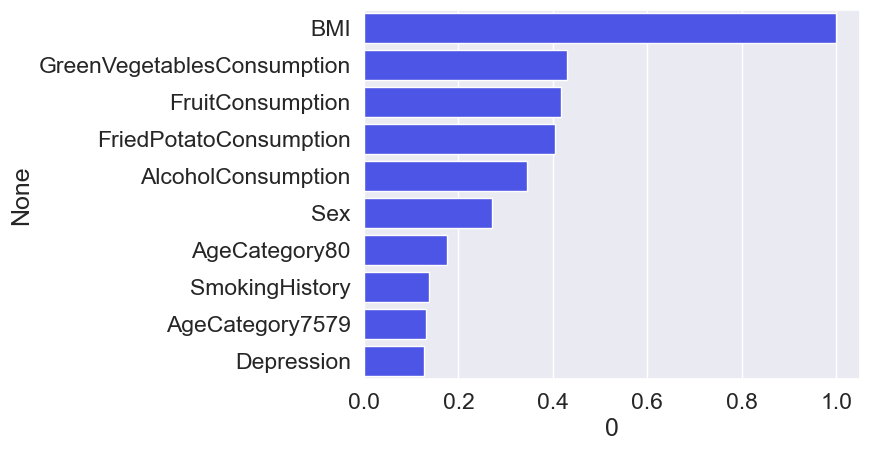

In [61]:
sns.barplot( x=x[0],y=x.index,palette=["#333fff"],errorbar=None)
plt.savefig('feat_import.png', transparent=True)